In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
import sys
import mat73
import os
import re
from scipy import stats
import shutil
from datetime import datetime

# FOOOF objects and functions
from fooof import FOOOFGroup, FOOOF
from fooof.bands import Bands
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model
from fooof.analysis import get_band_peak_fm, get_band_peak_fg


# RBL functions
from  import_NK_spectra import import_NK_spectra, import_FT_RCS_spectra
from  RBL_fooof_fxns import  setup_fooof_dirs, plt_save_fooof_analysis, plt_save_avg_peaks #plt_save_aperiodic_overtime, plt_save_periodic

In [51]:
### RBL inputs into general FOOOF approach below:
fooof_param = pd.DataFrame

fooof_param.freq_range = [2, 40] 

fooof_param.err_thresh = 0.15

## FOOOF alogirthim parameters (directly feed into FOOOF object)
fooof_param.peak_width_limits   = [2.0, 6.0]      # narrowest to widest possible peak width
fooof_param.max_n_peaks         = 4               # max number of peaks to fit
fooof_param.min_peak_height     = 0.1            # min power (db) ABOVE flattened spectrum to be considered a peak
fooof_param.peak_threshold      = 2               # min std(s) above flattened spectrum to be considered a peak
fooof_param.aperiodic_mode      ='fixed'          # 'fixed' = 1/(f^x), but 'knee' = 1/(k + f^x)--the latter allows an inflection point in the aperiodic fit

In [53]:
pts = ['RCS02', 'RCS04', 'RCS05', 'RCS06', 'RCS07']
nk_periodic_spectra_ls = []



### RBL inputs into general FOOOF approach below:
dirs = {'raw':       '/Volumes/DBS Pain 3/nk_device_data/processed/fooof_specs (30s_prior_to_survey, updated channels)/',
        'proc':      '/Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra/',
        'raw_sub':   '',
        'proc_sub':  'fooofed',
        'rcs_raw':   '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/'
       }

RCS02
['RVPN 3-1']
(106, 1, 298)
(298,)


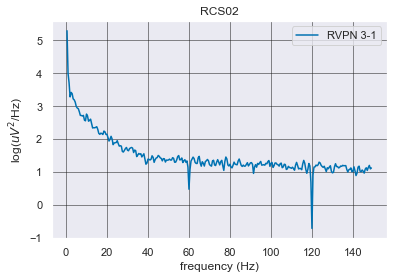

Running FOOOFGroup across 88 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS02/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
RCS04
['LACC 5-3', 'RACC 5-3', 'LACC 5-4', 'RACC 5-4']
(142, 4, 298)
(298,)


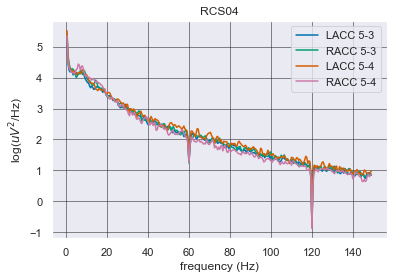

Running FOOOFGroup across 111 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS04/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 111 power spectra.
RCS05
['LACC 3-2', 'RINS 8-6', 'LACC 3-1', 'RINS 10-7']
(244, 4, 298)
(298,)


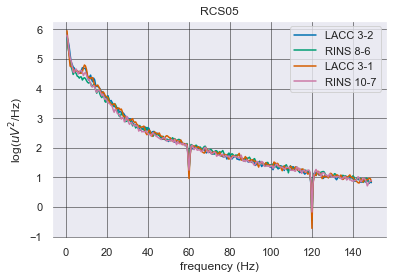

Running FOOOFGroup across 196 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS05/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 196 power spectra.
RCS06
['LCM 6-5', 'RACCa 7-6', 'LCM 7-6']
(304, 3, 298)
(298,)


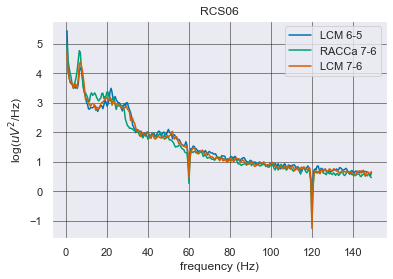

Running FOOOFGroup across 228 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS06/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 228 power spectra.
RCS07
['LSGC 3-2', 'RSGC 2-1', 'RSGC 3-1']
(236, 3, 298)
(298,)


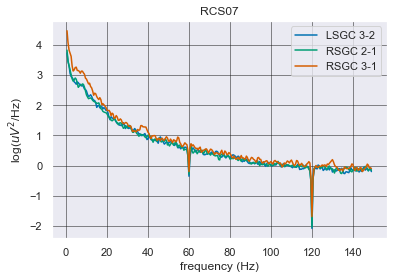

Running FOOOFGroup across 207 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS07/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 207 power spectra.


In [53]:
for i in range(len(pts)):
    
    raw_pwrspectra, fft_bins_inHz, ch_names, arm1_df = import_NK_spectra(pts[i], dirs)

    setup_fooof_dirs(pts[i], dirs, fooof_param)

    t_peri_ephy     = arm1_df.scales_vasmpq_timestamp
    i_keep          = [pd.isnull(t) == 0 for t in t_peri_ephy] 
    t_peri_ephy     = pd.to_datetime(t_peri_ephy.iloc[i_keep]).reset_index()
    t_peri_ephy     = t_peri_ephy.scales_vasmpq_timestamp

    bool_chan       = [any(a_ch == sense_homologs.loc[sense_homologs['pt'] == pts[i], 'NK_label']) for a_ch in ch_names]
    ind_sense_chan  = [i for i, x in enumerate(bool_chan) if x]

    #ind_sense_chan  = range(len(ch_names)-1)
    
    for i_ch in ind_sense_chan:
        spectra_oi = raw_pwrspectra[i_keep, i_ch, :]

        # FOOOF all spectra individually in single run
        fg = FOOOFGroup(
                        peak_width_limits  = fooof_param.peak_width_limits, 
                        max_n_peaks        = fooof_param.max_n_peaks, 
                        min_peak_height    = fooof_param.min_peak_height,
                        peak_threshold     = fooof_param.peak_threshold,
                        aperiodic_mode     = fooof_param.aperiodic_mode)

        # Model the power spectrum with FOOOF
        fg.fit(fft_bins_inHz, spectra_oi, fooof_param.freq_range)

        ### save aperiodic parameters, plot corr(aperiodic, time)
        [aperiodic_comp, raw_spectra, 
        fooof_spectra_aperiodic_rmv, freq_oi]   =  plt_save_fooof_analysis(pts[i], dirs, ch_names[i_ch], fooof_param, t_peri_ephy, fg)

        
        periodic_spectra = pd.DataFrame(
                            data   = fooof_spectra_aperiodic_rmv,
                            columns =  np.round(freq_oi, 1),
                            )

        periodic_spectra['pt_hemi'] = [pts[i]+ch_names[i_ch][0]]*fooof_spectra_aperiodic_rmv.shape[0]
        periodic_spectra['pt_chan'] = [ch_names[i_ch]]*fooof_spectra_aperiodic_rmv.shape[0]

        nk_periodic_spectra_ls.append(periodic_spectra)
        ### only needed once per loop   
        if i_ch == ind_sense_chan[0]:
            pd.DataFrame(fg.freqs).to_excel(dirs['fooof_data'] + 'fooof_freqs.xlsx', index=False)
            print('See:   ' + dirs['error'] + '\nfor spectra with model error >' +  str(fooof_param.err_thresh))

# Supervised ML of ambulatory hemisphere spectra from inpatient spectra
Inputs

center frequencies from inpatient and ambulatory spectra (neuro-electrophysiology from the NK and RC+S, respectively)

* both from '1_nk_fooof_spectra' and '1_rcs_fooof_spectra'


Goals

Use Random Forest and/or Logistic Regression to identify pt hemisphere from spectra alone **within inpatient** stage

--> use ML on ambulatory stage (while never using ambulatory stage data in training)


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

import seaborn as sns
from sklearn import metrics
sns.set_theme()

In [55]:
ALL_periodic_spectra = pd.concat(nk_periodic_spectra_ls, 
                                 ignore_index=True,
                                  axis =0)

print('shape of "ALL_periodic_spectra" is: ' + str(ALL_periodic_spectra.shape))

n_col      = len(ALL_periodic_spectra.columns)
i_freq_var = np.zeros(n_col, dtype=bool)

for i_col in range(n_col):
    if type(ALL_periodic_spectra.columns[i_col]) == float:
        i_freq_var[i_col] = True

shape of "ALL_periodic_spectra" is: (1572, 79)


In [56]:
for i_spec in range(ALL_periodic_spectra.shape[0]):
    
    spec      = ALL_periodic_spectra.iloc[i_spec, i_freq_var]
    spec_mean = np.mean(spec,0)
    
    ALL_periodic_spectra.iloc[i_spec, i_freq_var] = np.array(spec - spec_mean)

In [67]:
min_pwr = np.round(
                    (min(map(min,ALL_periodic_spectra.iloc[:, i_freq_var].values))),
                    1)
max_pwr = np.round(
                   (max(map(max,ALL_periodic_spectra.iloc[:, i_freq_var].values))),
                    1)

max_pwr = np.round(max_pwr *.1 +max_pwr, 1)

In [89]:
np.unique(periodic_spectra.pt_chan)[0]

'RSGC 2-1'

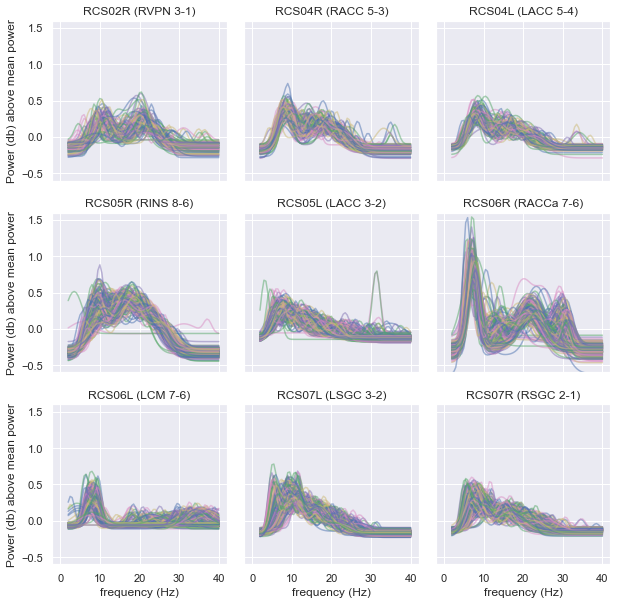

In [90]:
pt_sides = ['RCS02R', 'RCS04R', 'RCS04L', 'RCS05R', 'RCS05L', 'RCS06R','RCS06L','RCS07L', 'RCS07R']

fig, axes = plt.subplots(3,3, figsize=[10,10], sharex=True, sharey=True,
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.1})

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

for i, ax in enumerate(axes):

    i_hemi    = ALL_periodic_spectra.pt_hemi == pt_sides[i]
    tmp_spec  = ALL_periodic_spectra[i_hemi]

    plt_spec = tmp_spec.iloc[:, i_freq_var].values

    for i_sess in range(plt_spec.shape[0]):
        ax.plot(freq_oi, plt_spec[i_sess, :], False, alpha=0.5)
        
        plt.ylim([min_pwr, max_pwr])
        
    ch_name = np.unique(tmp_spec.pt_chan)[0]
    
    ax.set_title(pt_sides[i] +' ('+ch_name+')')
    
    if i % 3 == 0:
        ax.set_ylabel('Power (db) above mean power')
        
    if i >= 6:
        ax.set_xlabel('frequency (Hz)')

In [76]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    ALL_periodic_spectra.iloc[:, i_freq_var].values,
                                                    ALL_periodic_spectra['pt_hemi'], 
                                                    test_size=.2,
                                                    random_state=42
                                                    )

In [77]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=42)

In [78]:
his_boost     = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
y_pred_hist   = his_boost.predict(X_test)

In [82]:
def plt_conf_mat(y_test, y_pred, pt_sides):
    
    cm    = metrics.confusion_matrix(y_test, y_pred, normalize = 'true')
    score = accuracy_score(y_test, y_pred_hist)
    plt.figure(figsize=(8, 8))
    
    sns.heatmap(cm, 
                annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels = pt_sides, 
                yticklabels = pt_sides);
    
    plt.ylabel('Actual hemisphere');
    plt.xlabel('Predicted hemisphere');
    
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    
    return

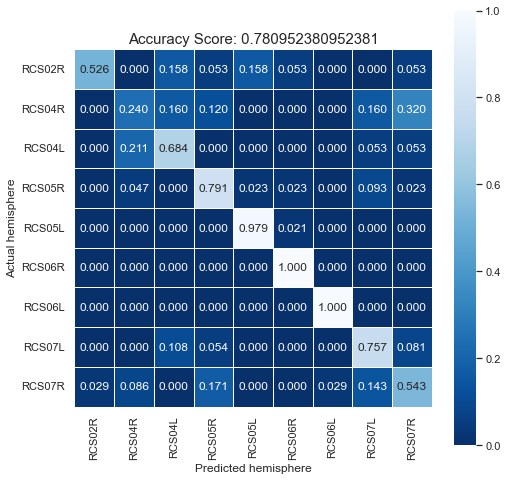

In [83]:
plt_conf_mat(y_test, y_pred_hist, pt_sides)

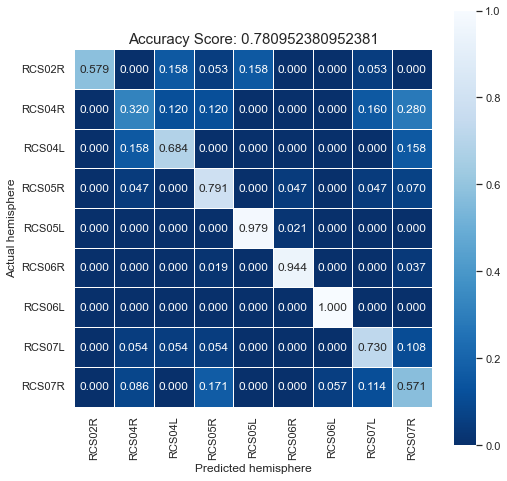

In [84]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf     = rf_classifier.predict(X_test)

# Calculate accuracy scores
plt_conf_mat(y_test, y_pred_rf, pt_sides)